## Aim 2 - Evaluate growth rate and yield under different carbon constraints

Figure 3a from [Alleman et al](pmc.ncbi.nlm.nih.gov/articles/PMC8686835/) shows growth rate vs growth yield of _Azobacter vinelandii_ under different oxygen concentrations and sucrose uptake rates. In this aim, we want to do similar comparisons with growth rate and yield when the media is composed of different carbon sources (sucrose, glucose, fructose, acetate). ATPM rates will be utilized from $108 \mu M\  O_2$.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import cobra

In [2]:
# load atpm data generated from aim 1 and sucrose concentration data from the paper
sucrose_rates = pd.read_excel('./data/alleman_table_s2.xlsx', index_col=0)
atpm_vals = pd.read_csv('./data/atpm.csv', index_col=[0, 1]).squeeze()
original_model = cobra.io.load_json_model('./data/iAA1300.json')
model = original_model.copy()

### Calculating Growth Yield vs Growth Rate

Open question - should we normalize by carbon #? molecular weight? Or not normalize at all?

Choosing to normalize since the results are very much stratified by carbon count/molecular weight and acetate shows no growth under ATPM constraints.
If ATPM was actually measured for each source we would have a better estimate.

In [3]:
atpm_constraint = atpm_vals[('partial', 108)]
sucrose_rates_sub = sucrose_rates[(sucrose_rates['O2_conc'] == 108) & (sucrose_rates['ETS_path'] == 'NII_BD_R')]
sucrose_rates_sub = sucrose_rates_sub['Sucrose_uptake_gcdw']

In [4]:
# Carbon source fluxes of interest (glucose, fructose, sucrose, acetate)
sources = ['glucose', 'fructose', 'sucrose', 'acetate']
source_reacs = ['EX_glc__D_e', 'EX_fru_e', 'EX_sucr_e', 'EX_ac_e']
mol_weights = [180.16, 180.16, 342.2965, 59.044]
normalizing_mol_weight = 342.2965  # since experiments were done with sucrose

In [5]:
# Set base model, which has experimentally determined ATPM rate and no carbon source uptake
model_no_uptake = original_model.copy()
for source_reac in source_reacs:
  model_no_uptake.reactions.get_by_id(source_reac).bounds = [0, 0]
model_no_uptake.reactions.ATPM.bounds = [atpm_constraint, 1000]
model_no_uptake.reactions.EX_nh4_e.bounds = [0, 0]
model_no_uptake.reactions.NADH6.bounds = [0, 0]
model_no_uptake.reactions.CYOO2pp.bounds = [0, 0]
model_no_uptake.reactions.FIX.bounds = [0, 0]
  

In [ ]:
# Calculate the growth rate of each pathway with and without normalizing by sucrose uptake rate
uptake_rate = []
carbon_source = []
growth_rate_adj = []
growth_rate = []
for rate in sucrose_rates_sub:
  for source, source_reac, mol_weight in zip(sources, source_reacs, mol_weights):
    uptake_rate.append(rate)
    carbon_source.append(source)
    
    model = model_no_uptake.copy()
    model.reactions.get_by_id(source_reac).bounds = [-rate, -rate]
    res = model.optimize()
    growth_rate.append(res.objective_value)

    rate_normalized = rate * (normalizing_mol_weight / mol_weight)  # Normalize rate so that same # grams of carbon source are available rather than same # moles
    model.reactions.get_by_id(source_reac).bounds = [-rate_normalized, -rate_normalized]
    res = model.optimize()
    growth_rate_adj.append(res.objective_value)

/usr3/graduate/dcscott/.local/lib/python3.12/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [39]:
growth_df = pd.DataFrame({
  'uptake': uptake_rate,
  'carbon_source': carbon_source,
  'growth_rate_adj': growth_rate_adj,
  'growth_rate': growth_rate
})
growth_df['growth_yield'] = growth_df['growth_rate'] / (growth_df['uptake'] / 1000)
growth_df['growth_yield_adj'] = growth_df['growth_rate_adj'] / (growth_df['uptake'] / 1000)

/scratch/ipykernel_1625129/2965695880.py:3: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.lineplot(growth_df, x = 'growth_rate', y = 'growth_yield', style = 'carbon_source', hue = 'carbon_source',
/scratch/ipykernel_1625129/2965695880.py:5: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.lineplot(growth_df, x = 'growth_rate_adj', y = 'growth_yield_adj', style = 'carbon_source', hue = 'carbon_source',


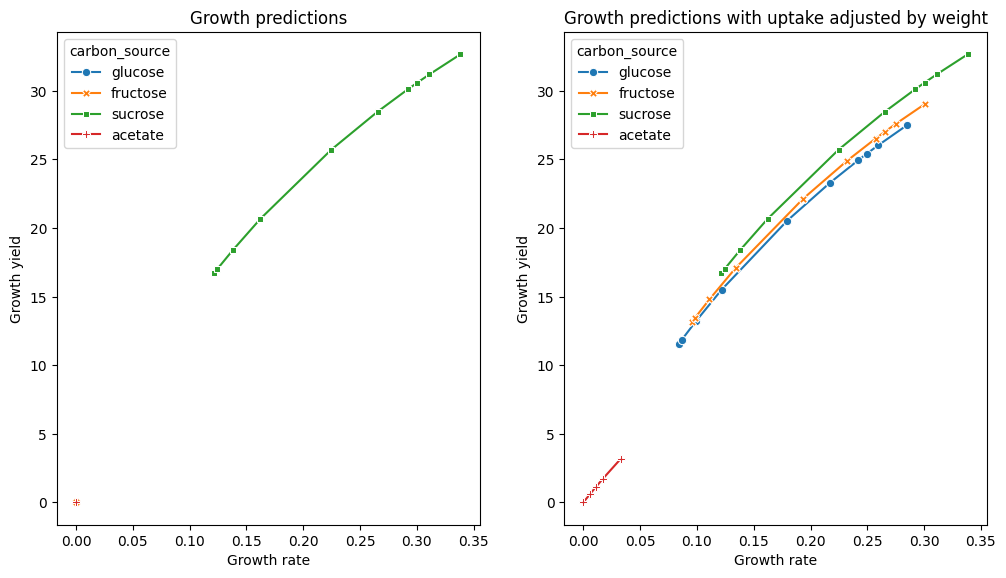

In [41]:
# Plot!
fig, [ax1, ax2] = plt.subplots(ncols = 2, figsize = (12, 6.4))
sns.lineplot(growth_df, x = 'growth_rate', y = 'growth_yield', style = 'carbon_source', hue = 'carbon_source',
                  palette = sns.color_palette("tab10"), markers = True, dashes = False, ax = ax1)
sns.lineplot(growth_df, x = 'growth_rate_adj', y = 'growth_yield_adj', style = 'carbon_source', hue = 'carbon_source',
                  palette = sns.color_palette("tab10"), markers = True, dashes = False, ax = ax2)
ax1.set_xlabel('Growth rate')
ax1.set_ylabel('Growth yield')
ax1.set_title("Growth predictions")
ax2.set_xlabel('Growth rate')
ax2.set_ylabel('Growth yield')
ax2.set_title("Growth predictions with uptake adjusted by weight")
plt.show()

### dFBA to observe how concentrations change over time in a complex media

[Tauchert et al](https://journals.asm.org/doi/10.1128/jb.172.11.6447-6451.1990) demonstrated that _A. vinelandii_ will preferentially consume acetate, then consume glucose once acetate has been depleted. To see if the model replicates this behavior, we will use dynamic FBA with fixed initial concentrations of acetate and glucose. It is unclear whether sodium will need to be added as well to account for sodium acetate being a paired transport reaction.

May need to model the (de)activation of involved enzymes, specifically glucose 6-phosphate dehydrogenase and acetate kinase

In [87]:
model.metabolites.accoa_c

Metabolite identifier,accoa_c
Name,Acetyl-CoA
Memory address,0x7f01c154b4d0
Formula,C23H34N7O17P3S
Compartment,c
In 40 reaction(s),"MACCOAT, ACCOAC, OXDHCOAT, ACS, ACACT1r, DHPACCOAHIT, ACACT7r, THPAT, AMPNTAT, OGCOAAT, 3OXCOAT, ACACT4r, HCITS, ACACT5r, ACACT3r, PDH, HMGL, ACACT2r, HSERTA, IPPS, PTAr, ACACT6r, ACACT8r, MMSAD3,..."


In [86]:
model.reactions.ACS

Reaction identifier,ACS
Name,Acetyl-CoA synthetase
Memory address,0x7f01c14e20c0
Stoichiometry,ac_c + atp_c + coa_c --> accoa_c + amp_c + ppi_c Acetate + ATP C10H12N5O13P3 + Coenzyme A --> Acetyl-CoA + AMP C10H12N5O7P + Diphosphate
GPR,Avin_10660 or Avin_34530 or Avin_42750
Lower bound,0.0
Upper bound,1000.0


In [134]:
# Set conditions from Tauchert paper (concentrations in mM)
initial_glucose = 15
initial_acetate = 33
atpm_constraint = atpm_vals[('partial', 48)]   # The paper uses 68, so we will use the closest concentration for our atpm flux.
sucrose_rate = sucrose_rates[(sucrose_rates['O2_conc'] == 48) & (sucrose_rates['ETS_path'] == 'NII_BD_R')]['Sucrose_uptake_gcdw'].iloc[0]

# We want to monitor enzyme levels as well, because acetate in the cell (acetyl CoA or acetyl phosphate) inhibits GPDH2r activity
acetate_enyzme = 'ACKr'
glucose_enzyme = 'G6PDH2r'
# Ends up not going through these pathways :|

In [135]:
# Run dFBA (some code taken from Lecture 12)
model = original_model.copy()
# model.reactions.ATPM.bounds = [atpm_constraint, atpm_constraint]
model.reactions.EX_sucr_e.bounds = [0, 0]
model.reactions.EX_nh4_e.bounds = [0, 0]
model.reactions.NADH6.bounds = [0, 0]
model.reactions.CYOO2pp.bounds = [0, 0]
model.reactions.FIX.bounds = [0, 0]

t_n = 100 # number of time points
dt = 0.5 # Time interval
timesteps = np.linspace(0, round(t_n * dt) - dt, t_n)

# Michaelis-Menten parameters for glucose and acetate uptake
KM = 0.5
Vmax = sucrose_rate
glu_effect = 1  # used to modify vmax for glucose based on acetate concentration

DFBA_biomass = np.zeros(t_n) # initialize vector of biomass amount
DFBA_GLC = np.zeros(t_n) # initialize vector of glucose amounts
DFBA_ACE = np.zeros(t_n)# initialize vector of acetate amounts

DFBA_biomass[0]=0.1 # Initial amount of biomass
DFBA_GLC[0]=initial_glucose # Initial amount of glucose
DFBA_ACE[0]=initial_acetate # Initial amount of acetate

for t in range(1, t_n):
  # Compute uptake rates using Michaelis-Menten
  DFBA_GLC_uptake = Vmax * glu_effect * DFBA_GLC[t-1]/(KM + DFBA_GLC[t-1])
  DFBA_ACE_uptake = Vmax * DFBA_ACE[t-1]/(KM + DFBA_ACE[t-1])

  # Impose Michaelis-Menten rate as maximal uptake rate for extracellular metabolites
  model.reactions.EX_glc__D_e.bounds = [-DFBA_GLC_uptake, 1000]
  model.reactions.EX_ac_e.bounds = [-DFBA_ACE_uptake, 1000]

  # Compute standard FBA solution (and check if feasible)
  solution = model.optimize()
  if(solution.status=='optimal'):
    vgrowth = solution.objective_value
    v_GLC = solution.fluxes.EX_glc__D_e
    v_ACE = solution.fluxes.EX_ac_e
    glu_effect = 1 - solution.fluxes[acetate_enyzme] / 10
  else:
    vgrowth=0
    v_GLC=0
    v_ACE=0
    glu_effect = 1

  # Update Biomass amount
  DFBA_biomass[t]=DFBA_biomass[t-1] + vgrowth*DFBA_biomass[t-1]*dt

  # Update glucose amount
  DFBA_GLC[t]=DFBA_GLC[t-1] + v_GLC*DFBA_biomass[t-1]*dt
  if(DFBA_GLC[t]<0):
    DFBA_GLC[t]=0

  # Update acetate amount
  DFBA_ACE[t]=DFBA_ACE[t-1] + v_ACE*DFBA_biomass[t-1]*dt
  if(DFBA_ACE[t]<0):
    DFBA_ACE[t]=0

/usr3/graduate/dcscott/.local/lib/python3.12/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [ ]:
# # find times at which glucose and acetate reach 0 for plotting purposes
# glc_0_time = np.nonzero(DFBA_GLC == 0.0)[0][0] * dt
# ace_0_time = np.nonzero(DFBA_ACE == 0.0)[0][0] * dt

IndexError: index 0 is out of bounds for axis 0 with size 0

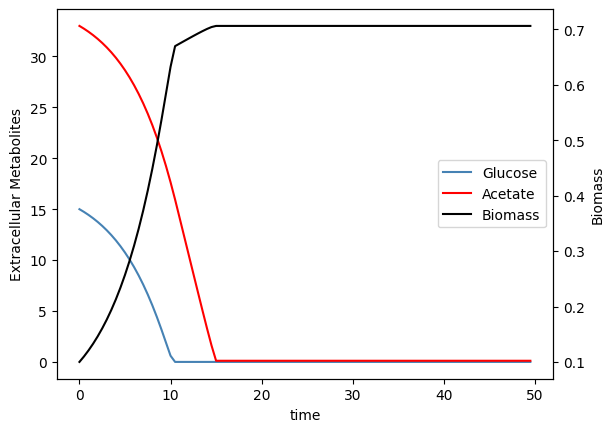

In [136]:
# plot results
ax = plt.subplot()
glc_lines = ax.plot(timesteps, DFBA_GLC, color='steelblue')
ace_lines = ax.plot(timesteps, DFBA_ACE, color='r')
ax.set_xlabel('time')
ax.set_ylabel('Extracellular Metabolites')
# ax.vlines([glc_0_time, ace_0_time], ymin=0, ymax=max(initial_acetate, initial_glucose), linestyles='--', colors=['steelblue', 'r'])

ax2 = ax.twinx()
bio_lines = ax2.plot(timesteps, DFBA_biomass, color='k')
ax2.set_ylabel('Biomass')

ax.legend(glc_lines + ace_lines + bio_lines, ['Glucose', 'Acetate', 'Biomass'], loc='center right')
plt.show()